# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

# Решение
Щаг в общем виде выглядит следующим образом: $$x^{k+1} = \arg\min_{x\in C} \;\Bigl(\gamma\langle\nabla f(x^k), x\rangle + \sum^{n}_{i = 1} x_iln x_i\Bigl) $$
В нашем случае: $$\nabla f(x^k) = Ax$$
Тогда задача оптимизации имеет следующий вид: $$ \min_{x\in\Delta_n}\;\gamma\langle Ax^k, x\rangle + \sum^{n}_{i = 1} x_iln x_i$$
Напишем ККТ: 
$$x\succcurlyeq 0$$
$$\langle x, \mathbb{1}\rangle = 1$$ 
$$\lambda_i\geq0$$ 
$$\lambda^Tx = 0 $$
$$\gamma(Ax^k)_i + lnx_i - lnx^k_i + 1 + u^T_i = 0$$
Отсюда имеем: 
$$x_i = \frac{x^k_i\exp(-\gamma(Ax^k)_i)}{\exp(1+u^T_i)} $$
$$\langle x, \mathbb{1}\rangle = 1$$
Тогда: $$x^* = x = \frac{x^k\exp(-\gamma Ax^k)}{\sum^{n}_{i = 1}x^k_i\exp(-\gamma (Ax^k)_i)}$$
То есть получили, что: $$ x^{k+1} = \frac{x^k\exp(-\gamma Ax^k)}{\sum^{n}_{i = 1}x^k_i\exp(-\gamma (Ax^k)_i)}$$ 

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

# Решение
Перепишем задачу в векторном виде: $$\max_{y\in\Delta_{d}}\Bigl(\nabla f^T(x^k) x^k - \nabla f^T(x^k) y\Bigl)$$ 
Первое слагаемое ни начто не влияет, поэтому задача переписывается так: $$ \min_{y\in\Delta_d} \nabla f^T(x^k) y$$
Тогда алгоритм решения будет такой: сортируем $\nabla f^T(x^k)$ по координатам, выбираем наименьшую, пусть она имеет индекс $i$, тогда $y^* = (0,\ldots,\underbrace{1}_{i},\ldots, 0)$. То есть выражение в явном виде: $$\text{gap}(x^k) = \langle \nabla f(x^k), x^k - y^* \rangle,$$ где $y^*$ определен строчкой выше.

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import time
np.random.seed(43)

In [3]:
def generator(d, mu, L):
    D = np.diag(np.repeat([L, mu], [d / 2 + 1, d / 2 - 1]))
    Sample = (L - mu) * np.random.rand(d, d) + mu
    Q, _ = np.linalg.qr(Sample)
    A = Q.T @ D @ Q
    return A

In [4]:
L = 1000
mu = 1
d = 100

In [5]:
A = generator(d, mu, L)

In [6]:
def f(x):
    return 1/2 * x.T @ A @ x

In [7]:
def grad_f(x):
    return A @ x

In [45]:
def EntropyMirror(f, grad_f,  gamma, eps = 10**(-2), max_iter = 10**6): 
    errors = []
    losses = []
    #В качестве начальной точки выбирается прокс-центр симплекса для энтропийной прокс-функции
    x_curr = np.ones(d) / d
    times = [0]
    time_now = 0
    
    while True:
        start_time = time()
        
        exp = np.exp(-gamma * grad_f(x_curr))
        
        x_new = (x_curr * exp) / (x_curr * exp).sum()
        
        errors.append(grad_f(x_new).T @ x_new - np.min(grad_f(x_new)))
        
        losses.append(f(x_new))
        
        x_curr = x_new
        
        if abs(grad_f(x_new).T @ x_new - np.min(grad_f(x_new))) < eps:
            break
        
        if len(errors) > max_iter:
            break
            
        end_time = time()
            
        time_now += end_time - start_time
        
        times.append(time_now)
            
    return x_new, errors, losses, times

In [46]:
x_EM, errors_EM, losses_EM, times_EM  = EntropyMirror(f, grad_f, 1/L, eps = 0.001)
f_EM = f(x_EM)
print('Решение, полученное методом зеркального спуска: \n', x_EM, '\n')
print('Значение зеркального спуска: ', f_EM, '\n')

Решение, полученное методом зеркального спуска: 
 [2.36134851e-03 2.16817740e-05 1.87880518e-03 2.51943374e-02
 1.53352679e-02 1.07372079e-02 2.31954985e-02 1.08672950e-02
 1.32875225e-02 7.37242153e-03 3.20082511e-04 2.09208023e-02
 1.32697312e-02 2.29082172e-02 2.28146319e-02 4.42673400e-03
 9.10108290e-03 3.45050211e-02 1.67625909e-02 4.57108692e-03
 5.53962413e-03 2.16361803e-02 1.94400151e-02 6.06819336e-04
 1.60012941e-02 3.54966817e-02 2.59201341e-02 1.80815146e-02
 6.20598693e-03 1.46534294e-03 2.32862863e-02 9.45880222e-03
 3.25400539e-04 6.77623774e-06 1.12735162e-04 1.66364688e-02
 8.55793212e-06 6.34049110e-03 2.18657831e-03 1.52629186e-03
 1.88868441e-02 1.24092355e-05 2.18161890e-06 2.49173426e-02
 2.52584111e-03 2.16328929e-03 1.81492624e-02 2.52544090e-03
 3.04074450e-04 2.34332690e-03 1.03173443e-02 3.12183832e-03
 1.02189155e-02 3.94857680e-03 1.20179355e-02 8.58045914e-03
 1.53498096e-02 2.59460932e-03 2.00727224e-02 5.68687575e-03
 1.73929007e-02 6.17620445e-03 9.74

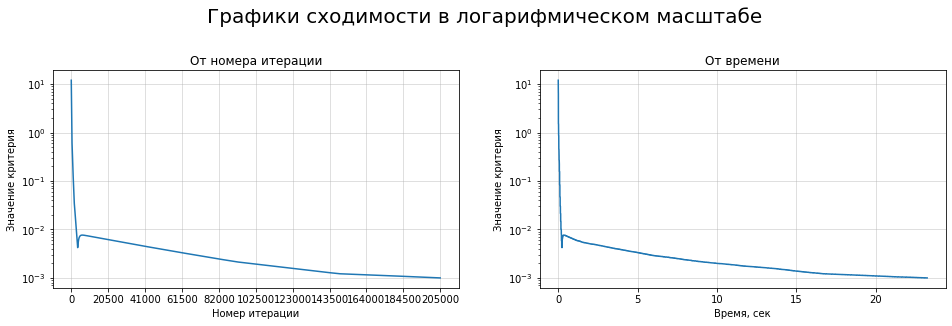

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle(r'Графики сходимости в логарифмическом масштабе', y = 1.1, fontsize = 20)
x_EM = np.array(range(len(errors_EM)))

ax[0].plot(x_EM, errors_EM)
ax[0].set_title("От номера итерации")
ax[0].set_xlabel("Номер итерации")
ax[0].set_ylabel("Значение критерия")
ax[0].set_xticks(np.array(range(0, len(errors_EM) + 100, round((len(errors_EM) + 1) / 10))))
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)

ax[1].plot(times_EM, errors_EM)
ax[1].set_title("От времени")
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)

plt.show()

Судя по графикам зеркальный спуск можно улучшить меняя динамически величину шага. То есть: мне видится, что выброс около нуля случается из-за слишком большого шага, поэтому мы проскакиваем оптимум и ошибка увеличивается.

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

Итерация метода Франк-Вульфа имеет следующий вид: 
$$s^k = \arg\min_{s\in C}\;\langle \nabla f(x^k), s - x^k\rangle$$
$$x^{k+1} = x^k + \gamma_k(s^k - x^k)$$
В нашем случае:
$$C =\Delta_d\;\;\text{и}\;\;\; \gamma_k = \frac{2}{k + 2}$$
Заметим, что $s^k$ мы уже научились вычислять в предыдущем пункте, а именно: соотвествующая задача минимизации переписывается вот так: $$\min_{s\in\Delta_d} \nabla f^T(x^k) s$$
Идентично предыдущей, то есть $s^k = s^* = (0,\ldots,\underbrace{1}_{i},\ldots, 0)$, где $i$ - индекс минимальной координаты $f^T(x^k)$.

Реализуем:

In [47]:
def FrankWolfe(f, grad_f, eps = 10**(-2), max_iter = 10**6):
    errors = []
    losses = []
    #В качестве начальной точки выбирается любая точка из множества С, например такая
    x_curr = np.insert(np.zeros(d - 1), np.random.randint(0, 100), 1)
    times = [0]
    time_now = 0
    
    while True:
        start_time = time()
        
        s = list(np.zeros(d - 1))
        s.insert(np.where(grad_f(x_curr) == np.min(grad_f(x_curr)))[0][0], 1)
        
        x_new = x_curr + (2 / (len(errors) + 2)) * (np.array(s) - x_curr)
        
        y = list(np.zeros(d - 1))
        y.insert(np.where(grad_f(x_new) == np.min(grad_f(x_new)))[0][0], 1)
        
        errors.append(grad_f(x_new).T @ (x_new - y))
        
        losses.append(f(x_new))
        
        if np.absolute(grad_f(x_new).T @ (x_new - y)) < eps:
            break
        
        x_curr = x_new
        
        if len(errors) > max_iter:
            break
            
        end_time = time()
            
        time_now += end_time - start_time
        
        times.append(time_now)
            
    return x_new, errors, losses, times

In [48]:
x_FW, errors_FW, losses_FW, times_FW  = FrankWolfe(f, grad_f, eps = 0.001)
f_FW = f(x_FW)
print('Решение, полученное методом Франк-Вульфа: \n', x_FW, '\n')
print('Значение метода Франк-Вульфа: ', f_FW, '\n')

Решение, полученное методом Франк-Вульфа: 
 [2.72314137e-03 7.85830634e-07 1.27045284e-03 2.49455181e-02
 1.49137557e-02 1.06458872e-02 2.33344574e-02 1.12578732e-02
 1.36815082e-02 7.37094031e-03 7.66375754e-06 2.10044202e-02
 1.33885229e-02 2.27959210e-02 2.22530708e-02 4.39112956e-03
 9.44247313e-03 3.38393003e-02 1.63309569e-02 4.68812525e-03
 5.71393167e-03 2.12132798e-02 1.95829786e-02 1.46636610e-05
 1.60760889e-02 3.47248628e-02 2.55770719e-02 1.79907858e-02
 6.04245707e-03 1.38635205e-03 2.29419570e-02 9.54995289e-03
 1.63883163e-05 7.36188459e-08 1.26403202e-06 1.65643937e-02
 4.21494653e-08 6.57400043e-03 1.94271609e-03 1.09808995e-03
 1.92484926e-02 0.00000000e+00 8.37280574e-09 2.48097341e-02
 2.12831227e-03 1.79861352e-03 1.81709362e-02 2.63175771e-03
 1.20556509e-06 2.48931505e-03 1.10244068e-02 3.06638387e-03
 1.07401219e-02 4.90713558e-03 1.19731225e-02 8.74467111e-03
 1.54036090e-02 2.41119370e-03 1.99062030e-02 6.03413505e-03
 1.77344783e-02 6.86031438e-03 1.01021900

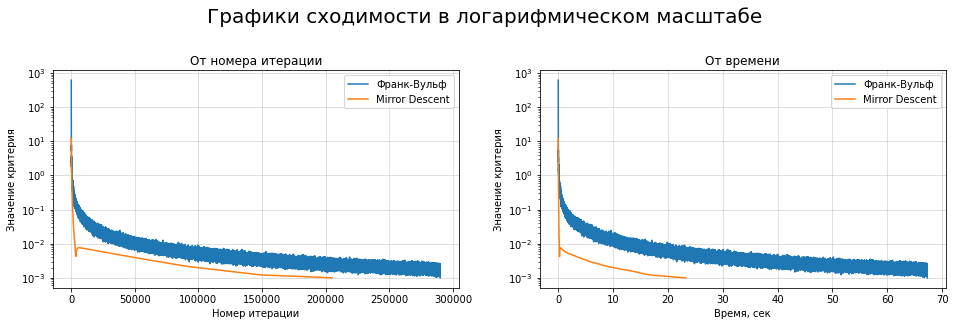

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle(r'Графики сходимости в логарифмическом масштабе', y = 1.1, fontsize = 20)
x_FW = np.array(range(len(errors_FW)))

ax[0].plot(x_FW, errors_FW, label = 'Франк-Вульф')
ax[0].plot(x_EM, errors_EM, label = 'Mirror Descent')
ax[0].set_title("От номера итерации")
ax[0].set_xlabel("Номер итерации")
ax[0].set_ylabel("Значение критерия")
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)
ax[0].legend(loc = 'upper right')

ax[1].plot(times_FW, errors_FW, label = 'Франк-Вульф')
ax[1].plot(times_EM, errors_EM, label = 'Mirror Descent')
ax[1].set_title("От времени")
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)
ax[1].legend(loc = 'upper right')

plt.show()

Как видно из графиков, зеркальный спуск работает быстрее, чем метод Франк-Вульфа. Характер сходимости метода Франк-Вульфа немонотонный.

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [25]:
from time import time
from tqdm import trange
from sys import stdout

Евклидова проекция на симплекс:

In [1]:
def proj_simplex(x):
    x_sort = sorted(x, reverse = True)
    crutch = 0
    summa = x_sort[0]
    ans = x_sort[0]
    for i in range(1, len(x_sort)):
        summa += x_sort[i]
        if x_sort[i] + 1 / (i + 1) * (1 - summa) > 0:
            crutch = i
            ans = summa
    lamb = 1 / (crutch + 1) * (1 - ans)
    x_answer = np.zeros(len(x_sort))
    for i in range(len(x_answer)):
        x_answer[i] = max(x[i] + lamb, 0)
    return x_answer

Реализация градиентного спуска:

In [41]:
def proj_gradient(grad_f, gamma, max_iter = 10**5, eps = 1e-7):
    x_cur = [1 / d] * d
    error = []
    times = [0]
    time_now = 0

    for i in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        start_time = time()
        
        x_new = proj_simplex(x_cur - gamma * grad_f(x_cur))
        x_cur = x_new

        error.append(abs(grad_f(x_new).T @ x_new - np.min(grad_f(x_new))))

        if error[-1] < eps:
            break
        
        end_time = time()
        time_now += end_time - start_time
        times.append(time_now)

    return x_new, error, times

 66%|█████████████████████████▋             | 263/400 [00:00<00:00, 5170.36it/s]


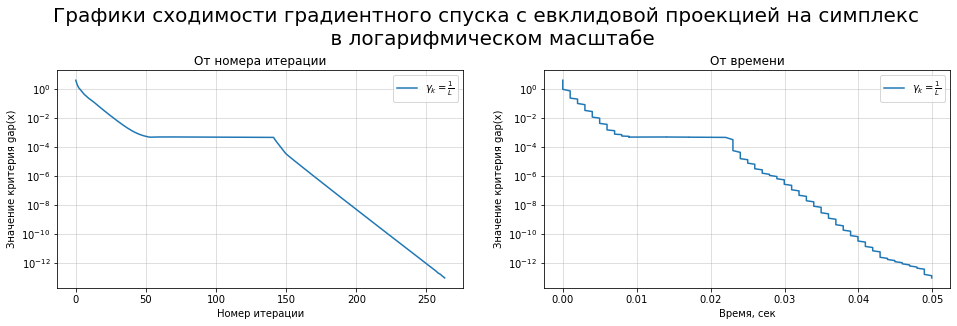

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle('Графики сходимости градиентного спуска с евклидовой проекцией на симплекс \n в логарифмическом масштабе', y = 1.1, fontsize = 20)
_, error, times = proj_gradient(grad_f, 1 / L, max_iter = 400, eps = 1e-13)

ax[0].plot(range(len(error)), error, label = r'$\gamma_k = \frac{1}{L}$')
ax[0].set_title("От номера итерации")
ax[0].set_xlabel("Номер итерации")
ax[0].set_ylabel("Значение критерия gap(x)")
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)
ax[0].legend(loc = 'upper right')

ax[1].plot(times, error, label = r'$\gamma_k = \frac{1}{L}$')
ax[1].set_title("От времени")
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия gap(x)")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)
ax[1].legend(loc = 'upper right')

plt.show()

Посмотрим в сравнении:

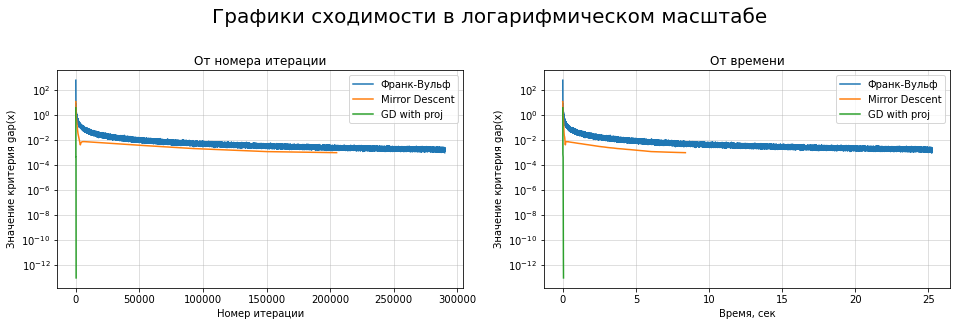

In [53]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle(r'Графики сходимости в логарифмическом масштабе', y = 1.1, fontsize = 20)
x_FW = np.array(range(len(errors_FW)))

ax[0].plot(range(len(errors_FW)), errors_FW, label = 'Франк-Вульф')
ax[0].plot(range(len(errors_EM)), errors_EM, label = 'Mirror Descent')
ax[0].plot(range(len(error)), error, label = 'GD with proj')
ax[0].set_title("От номера итерации")
ax[0].set_xlabel("Номер итерации")
ax[0].set_ylabel("Значение критерия gap(x)")
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)
ax[0].legend(loc = 'upper right')

ax[1].plot(times_FW, errors_FW, label = 'Франк-Вульф')
ax[1].plot(times_EM, errors_EM, label = 'Mirror Descent')
ax[1].plot(times, error, label = 'GD with proj')
ax[1].set_title("От времени")
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия gap(x)")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)
ax[1].legend(loc = 'upper right')

plt.show()

Тут бы просто оставить "слова излишни", но мы скажем: градиентный спуск с проекцией сходится кратно быстрее и кратно точнее чем оба предыдущих; конечно, возможно, что когда я 2 месяца назад их реализовывал, код писался сильно менее оптимально, но даже с учетом этого разница просто гигантская.

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [135]:
#Блок вспомогательных функций
def beta(k):
    return 2 * L / (k + 1)

def gamma(k):
    return 2 / (k + 2)

max_iter_alg1 = np.ceil(2 * np.sqrt(6 * L / mu)).astype(int)
p_0 = np.random.randn(d)
p_0 = p_0 / np.linalg.norm(p_0, ord = 2)
p_0[1] = 1

def eta(s):
    def eta_k(k):
        return 8 * L * f(p_0) * 2**(-(s + 1)) / (mu * max_iter_alg1 * (k + 1))
    return eta_k

In [127]:
def CndG(g, u, beta, eta):
    u_cur = u
    while True:
        
        est = g + beta * (u_cur - u)
        v = np.zeros(len(u))
        idx = np.argmin(g + beta * (u_cur - u))
        v[idx] = 1

        if est.T @ u_cur - np.min(est) <= eta:
            return u_cur
        
        alpha = min(1, ((-est).T @ (v - u_cur)) / (beta * np.linalg.norm(v - u_cur, ord = 2)**2))
        u_cur = (1 - alpha) * u_cur + alpha * v

In [152]:
def Algorithm1(grad_f, x_0, beta, gamma, eta, max_iter, eps = 1e-10):
    x = x_0
    y = x_0
    error = []
    times = []
    time_now = 0
    
    for i in range(max_iter):
        start_time = time()
        
        grad_y = grad_f(y)
        
        error.append(grad_y.T @ y - np.min(grad_y))
        
        if error[-1] < eps:
            break
        
        z = (1 - gamma(i)) * y + gamma(i) * x
        x = CndG(grad_f(z), x, beta(i), eta(i))
        y = (1 - gamma(i)) * y + gamma(i) * x
        
        end_time = time()
        time_now += end_time - start_time
        times.append(time_now)
        
    return y, error, times

In [153]:
def Algorithm2(grad_f, p_0,  beta, gamma, eta, max_iter_alg1, max_iter = 20):
    p = p_0
    times = []
    error = []
    start_time = time()
    
    for num_iter in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        process_time = time()
        
        p, error_alg1, time_alg1 = Algorithm1(grad_f, p, beta, gamma, eta(num_iter), max_iter_alg1)
        
        error += error_alg1
        
        time_alg1 = list(map(lambda x: process_time - start_time + x, time_alg1))
        times += time_alg1
        
    return p, error, times

In [154]:
_, er, ti = Algorithm2(grad_f, p_0, beta, gamma, eta, max_iter_alg1)

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.24it/s]


100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 11.84it/s]


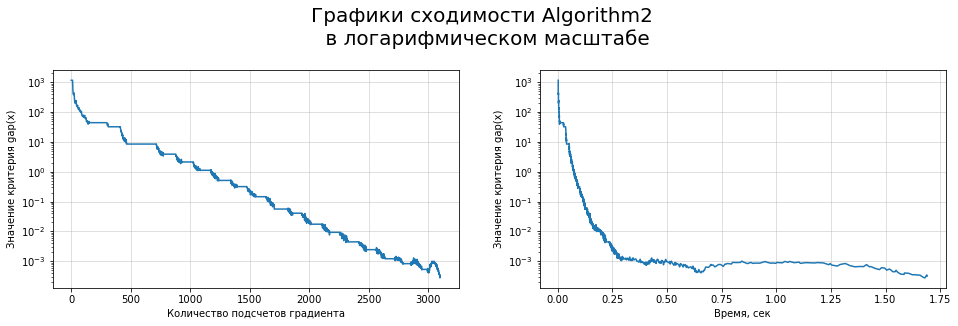

In [163]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle('Графики сходимости Algorithm2 \n в логарифмическом масштабе', y = 1.1, fontsize = 20)
_, er, ti = Algorithm2(grad_f, p_0, beta, gamma, eta, max_iter_alg1)

ax[0].plot(range(len(er)), er)
ax[0].set_xlabel("Количество подсчетов градиента")
ax[0].set_ylabel("Значение критерия gap(x)")
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)

ax[1].plot(ti, er)
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия gap(x)")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)

plt.show()

Сравним все вместе:

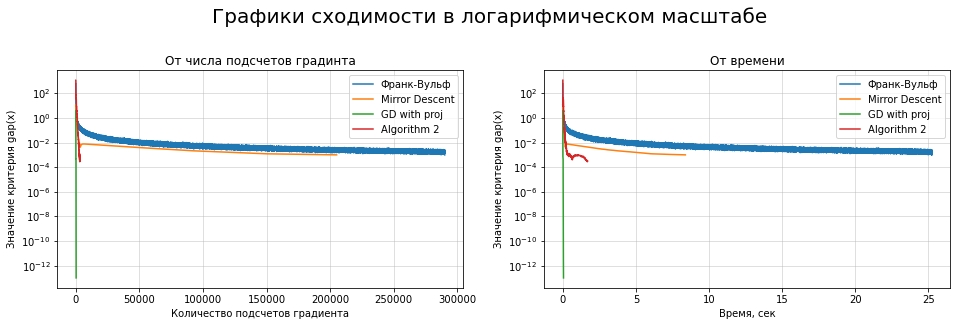

In [164]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
fig.suptitle(r'Графики сходимости в логарифмическом масштабе', y = 1.1, fontsize = 20)

ax[0].plot(range(len(errors_FW)), errors_FW, label = 'Франк-Вульф')
ax[0].plot(range(len(errors_EM)), errors_EM, label = 'Mirror Descent')
ax[0].plot(range(len(error)), error, label = 'GD with proj')
ax[0].plot(range(len(er)), er, label = 'Algorithm 2')
ax[0].set_title("От числа подсчетов градинта")
ax[0].set_xlabel("Количество подсчетов градиента")
ax[0].set_ylabel("Значение критерия gap(x)")
ax[0].set_yscale('log')
ax[0].grid(alpha = 0.5)
ax[0].legend(loc = 'upper right')

ax[1].plot(times_FW, errors_FW, label = 'Франк-Вульф')
ax[1].plot(times_EM, errors_EM, label = 'Mirror Descent')
ax[1].plot(times, error, label = 'GD with proj')
ax[1].plot(ti, er, label = 'Algorithm 2')
ax[1].set_title("От времени")
ax[1].set_xlabel("Время, сек")
ax[1].set_ylabel("Значение критерия gap(x)")
ax[1].set_yscale('log')
ax[1].grid(alpha = 0.5)
ax[1].legend(loc = 'upper right')

plt.show()

Как видно, ускоренная версия действительно отрабатывает лучше и быстрее обычной, однако справится с градиентным спуском все еще не может.